In [1]:
import sys
sys.path.append("../../")

In [2]:
SAVE_PATH = "../storage/demo/cnp_GP-1D_regression.ckpt"

# 1D Regression with CNPs and GPs in comparison

Here I reproduce Figure 2 of Garnelo et al.'s article on conditional neural processes.

In [3]:
from tqdm import tqdm     # Dynamic progress bars
import glob               # Lets us check if checkpoint files exist
import numpy as np        # 
import tensorflow as tf   # 

In [4]:
tf.logging.set_verbosity(tf.logging.ERROR)  # Suppress depreciation warnings
tf.__version__

'1.13.1'

In [5]:
from neuralprocesses.np.aux import DataProvider
from neuralprocesses.utils.tf_utils import tf_sort_by_col

from neuralprocesses.utils.gp import GaussianProcess
from neuralprocesses.utils.gp import squared_exponential_kernel

from neuralprocesses.np.cnp import ConditionalNeuralProcess

from neuralprocesses.utils.plotting import list_plot
from neuralprocesses.utils.plotting import Color


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [6]:
tf.reset_default_graph()
tf.set_random_seed(2019)

## Data provider

Setup a Gaussian process that provides the environment we want to sample from.

In [7]:
BATCH_SIZE = 32  # ToDo: Can we make this a placeholder?

In [8]:
plotting_mode = tf.placeholder(dtype=tf.bool, name="plotting_mode")
process = GaussianProcess(squared_exponential_kernel, name="environment-GP")
data_provider = DataProvider(process, batch_size=BATCH_SIZE)

In [9]:
data = data_provider(plotting_mode=plotting_mode)

In [10]:
x_context = data.queries[0][0]
y_context = data.queries[0][1]
x_target = data.queries[1]

## GP model setup

In [11]:
#kernel = lambda x: squared_exponential_kernel(x, 2.0)
gp_model = GaussianProcess(squared_exponential_kernel, name="gp-model")

In [12]:
_, gp_mean, gp_variance, _ = gp_model(((x_context, y_context), x_target))

In [13]:
with tf.variable_scope("gp_plot"):
    gp_plot_context = tf_sort_by_col(tf.stack([x_context[0], y_context[0]], axis=1), 0)
    gp_plot_mean = tf_sort_by_col(tf.stack([x_target[0], gp_mean[0]], axis=1), 0)
    gp_plot_max = tf_sort_by_col(tf.stack([x_target[0], gp_mean[0] + tf.sqrt(gp_variance[0])], axis=1), 0)
    gp_plot_min = tf_sort_by_col(tf.stack([x_target[0], gp_mean[0] - tf.sqrt(gp_variance[0])], axis=1), 0)

### Prediction function

In [14]:
def gp_predict(xc, yc, ground_truth_data):
    with tf.Session() as session:        
        xt = np.arange(-1., 1.01, 0.01)
        batch_size = BATCH_SIZE  # ToDo: How can we change the batch size after loading?

        # Compute a test case for plotting
        ctxt, xy, xymax, xymin = session.run(
            [gp_plot_context, gp_plot_mean, gp_plot_max, gp_plot_min],
            feed_dict={
                plotting_mode: True,
                data.queries[0][0]: [xc for b in range(batch_size)],
                data.queries[0][1]: [yc for b in range(batch_size)],
                data.queries[1]: [xt for b in range(batch_size)],
                data.num_context: len(xc),
                data.num_target: len(xt)
            }
        )

        # Plot the result
        list_plot([xy, xymin, xymax, ctxt, ground_truth_data],
              joined=[True,True,True,False], 
              mesh=[False,False,False,True],
              plot_style=[
                  # Mean in gray
                  Color((0.3,0.3,0.3)),  
                  # Confidence interval bounds in blue
                  Color.color_data(n=1),
                  Color.color_data(n=1),
                  # Context points as Red crosses
                  {"Color": Color.color_data(n=0), "Marker": "+", "PointSize": 300},
                  # Ground truth in black
                  Color((0,0,0))
              ],
              axes_label=("x", "y"),
              filling=[[1,2]]
        )

## CNP model setup and training

### Setup

In [15]:
cnp = ConditionalNeuralProcess(name="cnp-model")

In [16]:
cnp_mean, cnp_variance, cnp_loss = cnp(data)

In [17]:
with tf.variable_scope("cnp_trainer"):
    optimizer = tf.train.AdamOptimizer()
    training_step = optimizer.minimize(cnp_loss)

In [18]:
with tf.variable_scope("cnp_plot"):
    cnp_plot_context = tf_sort_by_col(tf.stack([x_context[0], y_context[0]], axis=1), 0)
    cnp_plot_mean = tf_sort_by_col(tf.stack([x_target[0], cnp_mean[0]], axis=1), 0)
    cnp_plot_max = tf_sort_by_col(tf.stack([x_target[0], cnp_mean[0] + tf.sqrt(cnp_variance[0])], axis=1), 0)
    cnp_plot_min = tf_sort_by_col(tf.stack([x_target[0], cnp_mean[0] - tf.sqrt(cnp_variance[0])], axis=1), 0)

### Training

In [19]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [20]:
NUM_EPISODES = 100000
SAVE_STEP = 10000

with tf.Session() as session:
    
    # Check if we already ran this code
    if len(glob.glob(SAVE_PATH + "*")) > 0:
        # Restore weights and settings from past run
        print(f"Restoring model from: {SAVE_PATH}")
        saver.restore(session, SAVE_PATH)
    else:    
        # Initialize variables
        init = tf.global_variables_initializer()
        saver = tf.train.Saver( 
            max_to_keep=4, 
            keep_checkpoint_every_n_hours=1
        )
        session.run(init)

        # Do training
        for episode in tqdm(range(NUM_EPISODES)):
            session.run(training_step, feed_dict={plotting_mode: False})
            
            if episode % SAVE_STEP == 0 or episode == NUM_EPISODES - 1:
                saver.save(session, SAVE_PATH, global_step=episode)
    
        # Save resulting graph
        print(f"Model saved in: {saver.save(session, SAVE_PATH)}")

100%|██████████| 100000/100000 [07:49<00:00, 212.98it/s]


Model saved in: ../storage/demo/cnp_GP-1D_regression.ckpt


### Prediction function

In [21]:
def cnp_predict(xc, yc, ground_truth_data):
    with tf.Session() as session:
        saver.restore(session, SAVE_PATH)
        
        xt = np.arange(-1., 1.01, 0.01)
        batch_size = BATCH_SIZE  # ToDo: How can we change the batch size after loading?

        # Compute a test case for plotting
        ctxt, xy, xymax, xymin = session.run(
            [cnp_plot_context, cnp_plot_mean, cnp_plot_max, cnp_plot_min],
            feed_dict={
                plotting_mode: True,
                data.queries[0][0]: [xc for b in range(batch_size)],
                data.queries[0][1]: [yc for b in range(batch_size)],
                data.queries[1]: [xt for b in range(batch_size)],
                data.num_context: len(xc),
                data.num_target: len(xt)
            }
        )

        # Plot the result
        list_plot([xy, xymin, xymax, ctxt, ground_truth_data],
              joined=[True,True,True,False], 
              mesh=[False,False,False,True],
              plot_style=[
                  # Mean in gray
                  Color((0.3,0.3,0.3)),  
                  # Confidence interval bounds in blue
                  Color.color_data(n=1),
                  Color.color_data(n=1),
                  # Context points as Red crosses
                  {"Color": Color.color_data(n=0), "Marker": "+", "PointSize": 300},
                  # Ground truth in black
                  Color((0,0,0))
              ],
              axes_label=("x", "y"),
              filling=[[1,2]]
        )

## Testing

### Sample one function

In [22]:
with tf.Session() as session:
    xc, yc, xt, yt = session.run([
        x_context[0], y_context[0], x_target[0], data.targets[0]], feed_dict={plotting_mode: True})

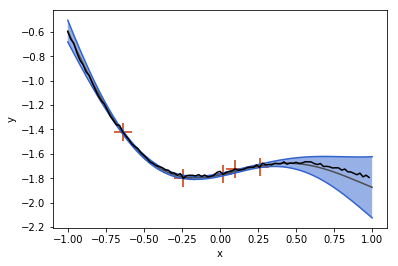

In [23]:
gp_predict(xc[:5], yc[:5], np.transpose([xt, yt]))

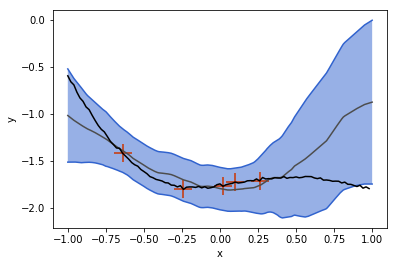

In [24]:
cnp_predict(xc[:5], yc[:5], np.transpose([xt, yt]))

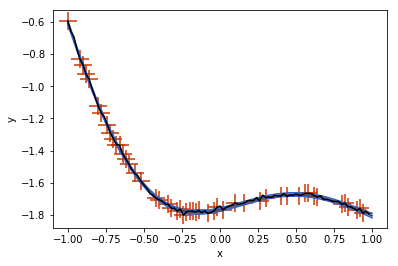

In [25]:
gp_predict(xc[:50], yc[:50], np.transpose([xt, yt]))

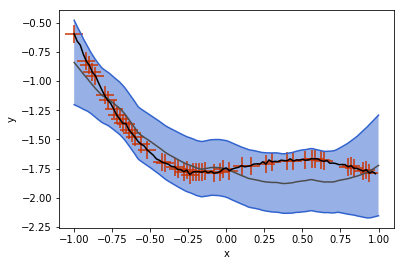

In [26]:
cnp_predict(xc[:50], yc[:50], np.transpose([xt, yt]))